# Last Hope and all Tasks

## Setup

In [35]:
#Für Colab
!git clone -b master https://github.com/HennFarr/Coins.git
!pip install keras_tuner
!pip install shap

fatal: destination path 'Coins' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [103]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins.hparams import api as hp
from tensorflow import keras


from keras import layers
import keras_tuner as kt
from keras.preprocessing.image import ImageDataGenerator, img_to_array,load_img

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import shap


### Local or Google Colab 

In [2]:
local_data_dir="new_extended_dataset/original"
colab_data_dir="/content/Coins/new_extended_dataset/original"

### Data

#### Clear Data

In [38]:
num_skipped = 0
for folder_name in ("1c", "1e", "2c", "2e", "5c", "10c", "20c","50c"):
    folder_path = os.path.join(local_data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


#### Get Data

In [4]:
batch_size=64   
target_size = 200

In [5]:
# Training split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_data_dir,
    labels='inferred',
    label_mode='int',
    class_names=["1c", "2c", "5c", "10c", "20c", "50c", "1e", "2e"],
    validation_split=0.25,
    subset="training",
    seed=42,
    image_size=(target_size,target_size),
    batch_size=batch_size,
)

Found 9664 files belonging to 8 classes.
Using 7248 files for training.


In [34]:
# Validation split
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    local_data_dir,
    labels='inferred',
    label_mode='int',
    class_names=["1c", "2c", "5c", "10c", "20c", "50c", "1e", "2e"],
    validation_split=0.25,
    subset="validation",
    seed=42,
    image_size=(target_size,target_size),
    batch_size=batch_size,
)

Found 9664 files belonging to 8 classes.
Using 2416 files for validation.


In [35]:
# Test split
# 38 Batches/2
test_ds = val_ds.take(19)
val_ds = val_ds.skip(19)

## Visualisierung 

In [9]:
class_names = train_ds.class_names

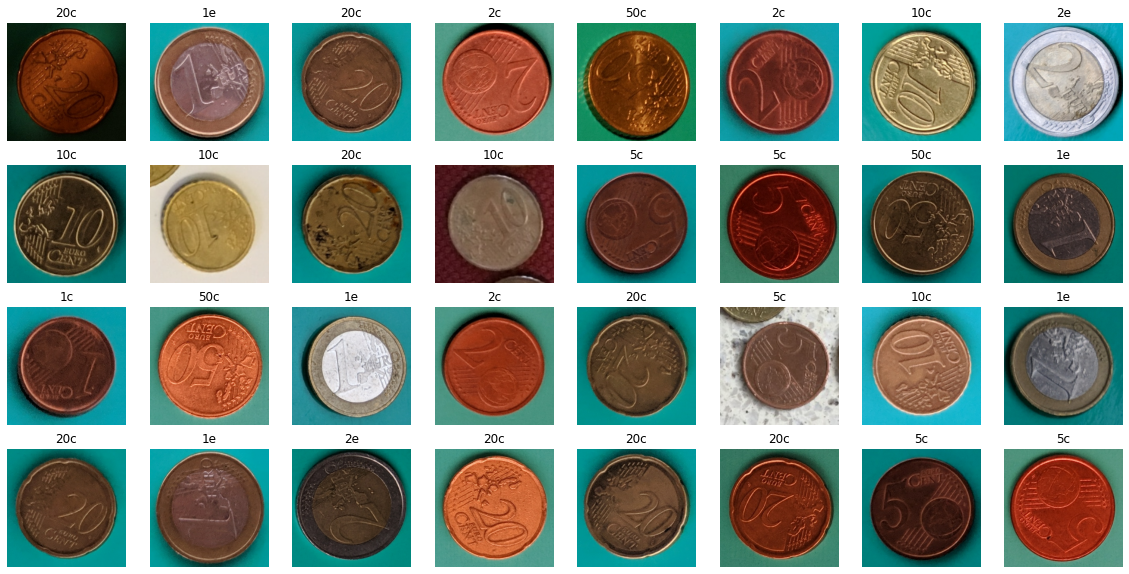

In [36]:
# First 32 images + label of the first TRAINING batch
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
  x_train=images    #For later
  y_train=labels    #For later
  for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

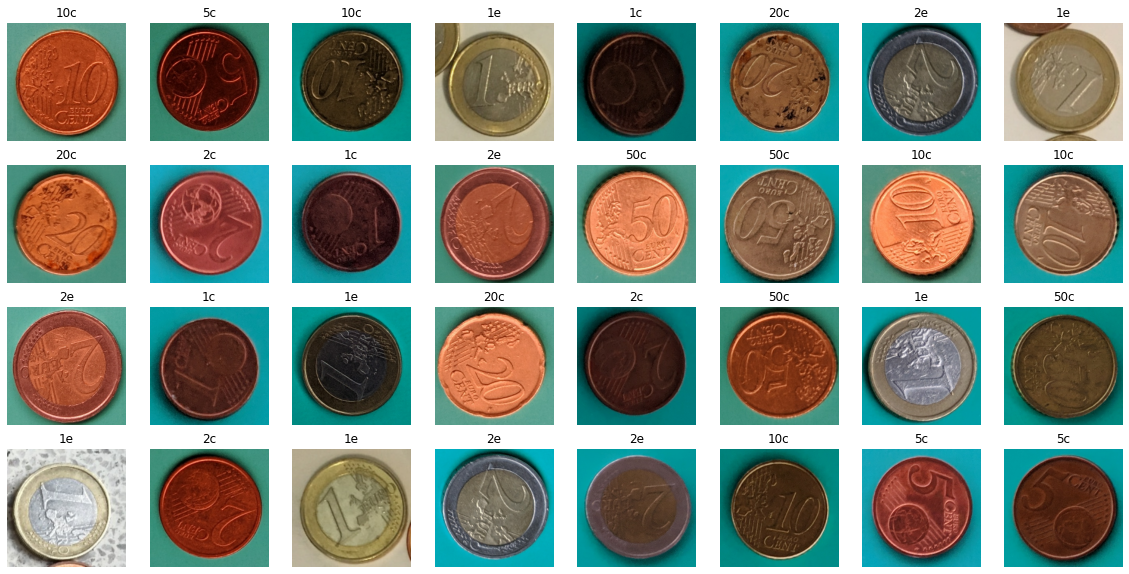

In [37]:
# First 32 images + label of the first VALIDATION batch
plt.figure(figsize=(20, 10))
for images, labels in val_ds.take(1):
  x_val=images   #For later
  y_val=labels   #For later
  for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

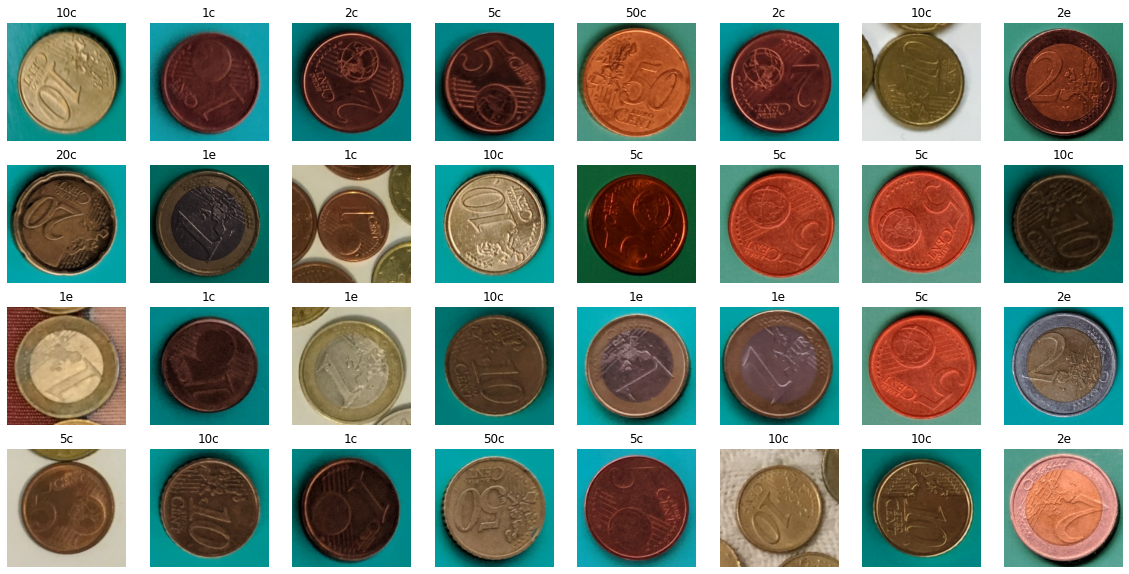

In [38]:
# First 32 images + label of the first TEST batch
plt.figure(figsize=(20, 10))
for images, labels in test_ds.take(1):
  x_test=images   #For later
  y_test=labels   #For later
  for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model Building

In [40]:
train_ds = train_ds.prefetch(buffer_size=64)
val_ds = val_ds.prefetch(buffer_size=64)

### Data Augmentation 

In [48]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomContrast(factor=0.5),
])

### Model & Layers
>specific comments missing
### Compiling
- 'categorical_crossentropy' works on one-hot encoded label
- 'sparse_categorical_crossentropy' works on integer label


In [49]:
def build_model(hp):
    inputs = keras.Input(shape=(target_size,target_size, 3))

    x = data_augmentation(inputs)

    x = layers.Rescaling(1.0 / 255)(x)

    x = layers.Conv2D(filters=16, kernel_size=3, strides=2, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    for n_filters in [64, 128, 256, 512]:
        x = layers.Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Conv2D(filters=n_filters, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(n_filters, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual


    x = layers.Conv2D(filters=728, kernel_size=3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)

    x = layers.SpatialDropout2D(0.5)(x)
    
    #GAP2DvsFlatten
    if hp.Boolean("GAPvsFlatten"):
        x = layers.GlobalAveragePooling2D()(x)
    else:
        x = layers.Flatten()(x)

    outputs = layers.Dense(8, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    #Compile 
    model.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

    return model
    #model.summary()

In [50]:
build_model(kt.HyperParameters())

In [51]:
#keras.utils.plot_model(model, show_shapes=True)

### Callback
- Saving best Model 
- Early Stopping not suitable (s. history below)

In [41]:
local_model_dir = "Models/Tuned/tuned_model"
colab_model_dir = "/content/Coins/Models/Tuned/tuned_model"

In [53]:
callbacks = [
    keras.callbacks.ModelCheckpoint(colab_model_dir, save_best_only=True),
    #keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.01, patience=4)
]

## Model Tuning / Training
>Needs to be done in Google Colab

In [54]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=2,               #Only True or False
    executions_per_trial=1,     #Saving Time
    overwrite=True,
    directory="Models/Tuned/search",
    project_name="Coin Classification",
)

tuner.search_space_summary()

Search space summary
Default search space size: 1
GAPvsFlatten (Boolean)
{'default': False, 'conditions': []}


In [55]:
tuner.search(
    train_ds,
    epochs=50,
    validation_data=val_ds
)

Trial 2 Complete [00h 32m 03s]
val_accuracy: 0.9896523356437683

Best val_accuracy So Far: 0.995447039604187
Total elapsed time: 01h 05m 11s
INFO:tensorflow:Oracle triggered exit


In [62]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('GAPvsFlatten'))
model = tuner.hypermodel.build(best_hps)
model.summary()

True
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 200, 200, 3)  0           ['input_5[0][0]']                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 200, 200, 3)  0           ['sequential[7][0]']             
                                                                                                  
 conv2d_60 (Conv2D)             (None, 100, 100, 16  448         ['rescaling_4[0][0]'] 

In [57]:
history = model.fit(
    train_ds, 
    epochs=50, 
    callbacks=callbacks, 
    validation_data=val_ds,
)

Epoch 1/50
114/114 [==============================] - 42s 348ms/step - loss: 1.4693 - accuracy: 0.4677 - val_loss: 2.3699 - val_accuracy: 0.1457
Epoch 2/50
114/114 [==============================] - 35s 298ms/step - loss: 0.9866 - accuracy: 0.5869 - val_loss: 3.5857 - val_accuracy: 0.1387
Epoch 3/50
114/114 [==============================] - 35s 298ms/step - loss: 0.8680 - accuracy: 0.6342 - val_loss: 3.2228 - val_accuracy: 0.1834
Epoch 4/50
114/114 [==============================] - 35s 298ms/step - loss: 0.7859 - accuracy: 0.6697 - val_loss: 3.2124 - val_accuracy: 0.2111
Epoch 5/50
114/114 [==============================] - 42s 360ms/step - loss: 0.7096 - accuracy: 0.7057 - val_loss: 0.9700 - val_accuracy: 0.6093
Epoch 6/50
114/114 [==============================] - 41s 357ms/step - loss: 0.6723 - accuracy: 0.7294 - val_loss: 0.7634 - val_accuracy: 0.7185
Epoch 7/50
114/114 [==============================] - 40s 347ms/step - loss: 0.5879 - accuracy: 0.7637 - val_loss: 0.5824 - val_ac

### Training history

<function matplotlib.pyplot.show>

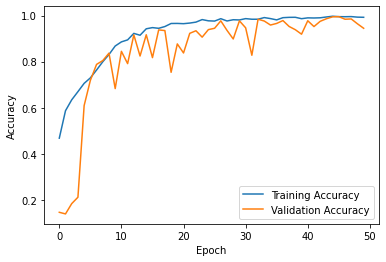

In [58]:
epochs_range = range(50)

plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

### Loading Model
> Loading Model in local environment for later evaluation

In [42]:
model_loaded = keras.models.load_model(local_model_dir)

In [43]:
test_loss, test_acc = model_loaded.evaluate(test_ds)

19/19 [==============================] - 34s 2s/step - loss: 0.0197 - accuracy: 0.9942


## Model Evaluation

In [47]:
predictions = model_loaded.predict(x_test)
#Rescaling 
x_test_r = x_test / 255

In [54]:
#Function by Kirenz
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(8))
  plt.yticks([])
  thisplot = plt.bar(range(8), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

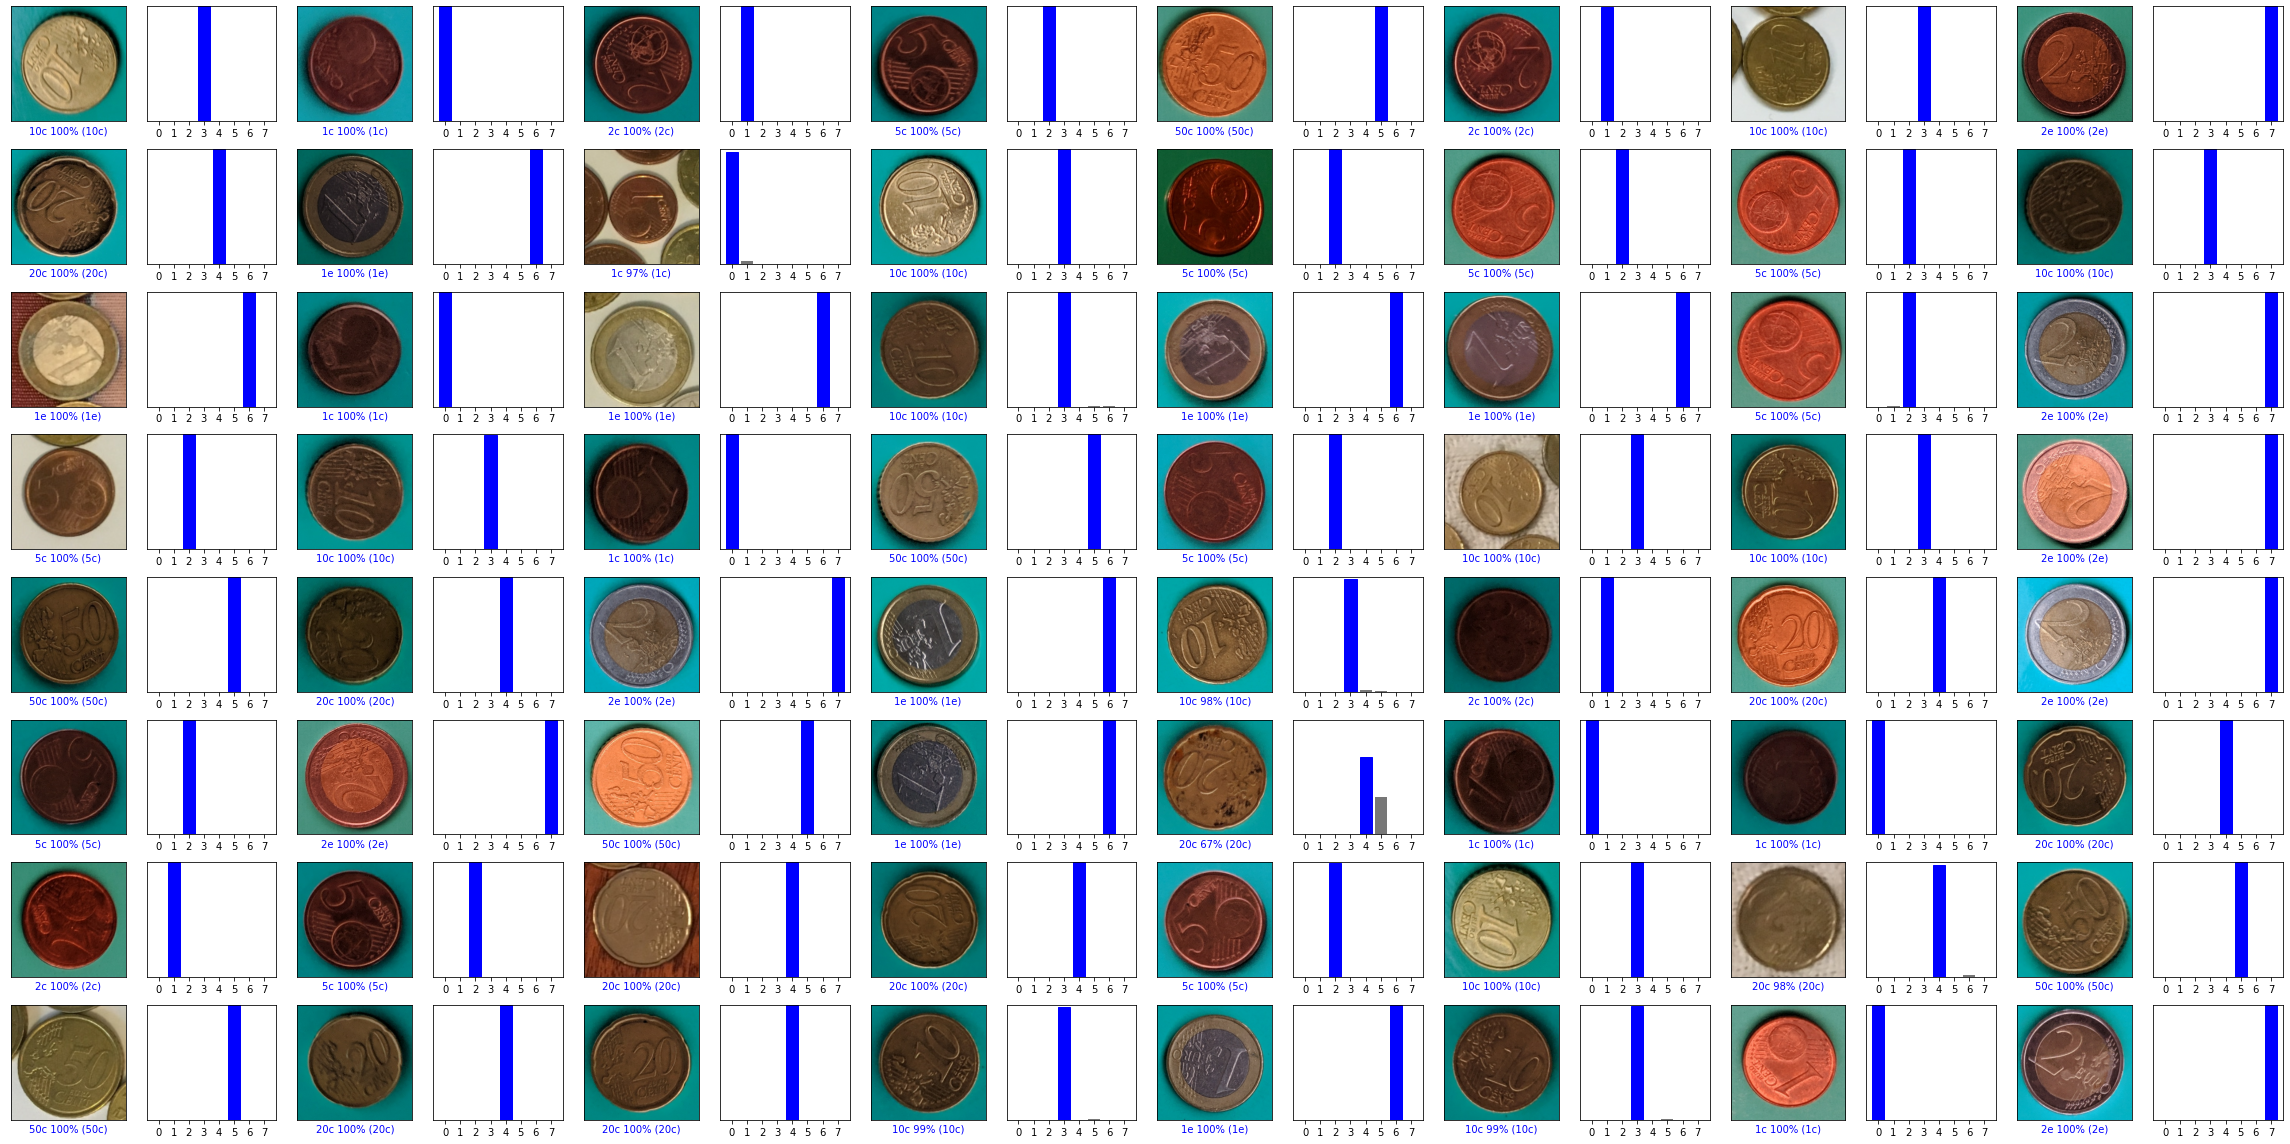

In [55]:
#Plot of the first Batch of test_ds
num_rows = 8
num_cols = 8
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], y_test, x_test_r)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

## Explainable AI

### CNN Filters

conv2d_15 (None, 100, 100, 16)
16
Red


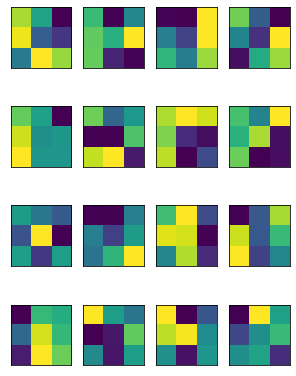

Green


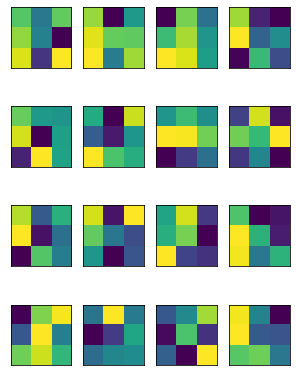

Blue


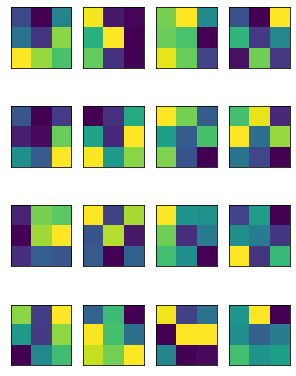

In [100]:
conv2_16 = model_loaded.layers[3]
weights, bias= conv2_16.get_weights()
print(conv2_16.name, conv2_16.output_shape)

f_min, f_max = weights.min(), weights.max()
filters = (weights - f_min) / (f_max - f_min)  
print(filters.shape[3])

n_filters=filters.shape[3]
columns=4
rows=4
RGB=["Red","Green","Blue"]
for c in range(3):
    fig=plt.figure(figsize=(5,7))
    print(RGB[c])
    for i in range(1, n_filters+1):
        f=filters[:,:,:, i-1]
        fig = plt.subplot(rows, columns, i)
        fig.set_xticks([])
        fig.set_yticks([])
        plt.imshow(f[:,:,c])    #RGB R:0
    plt.show()
    

### Feature Maps

conv2_16


invalid value encountered in true_divide


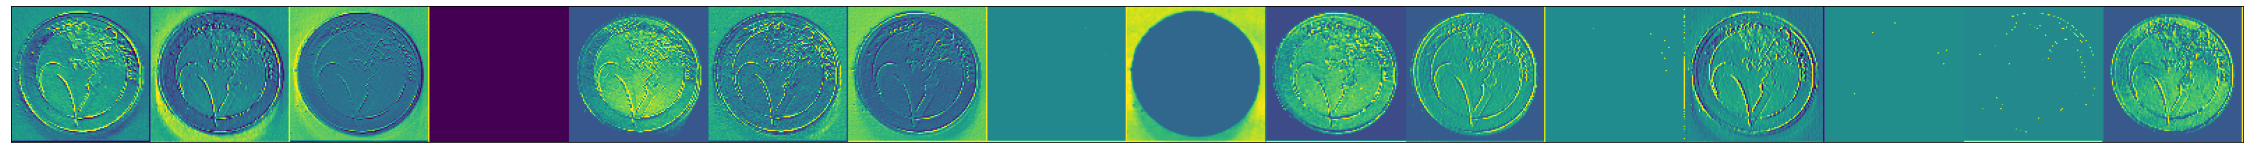

In [148]:
print("conv2_16")
output = model_loaded.layers[3].output
visualization_model = tf.keras.models.Model(inputs = model_loaded.input, outputs = output)

img = load_img(img_path_local, target_size=(200, 200))
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)

feature_map = visualization_model.predict(x)

n_features = feature_map.shape[-1]  # number of features in the feature map
size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)

display_grid = np.zeros((size, size * n_features))

for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()           # invalid value ??
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x

scale = 40 / n_features
plt.figure(figsize=(scale * n_features, scale))
plt.grid(False)
plt.xticks([],[])
plt.yticks([],[])
plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()

### SHAP

In [149]:
np_x_train = x_train.numpy()
np_x_val = x_val.numpy()
np_x_test = x_test.numpy()

In [150]:
explainer = shap.GradientExplainer(model_loaded, np_x_train)

In [79]:
shap_values = explainer.shap_values(np_x_test[:8])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [81]:
print(len(shap_values))
print(len(shap_values[0]))

8
8


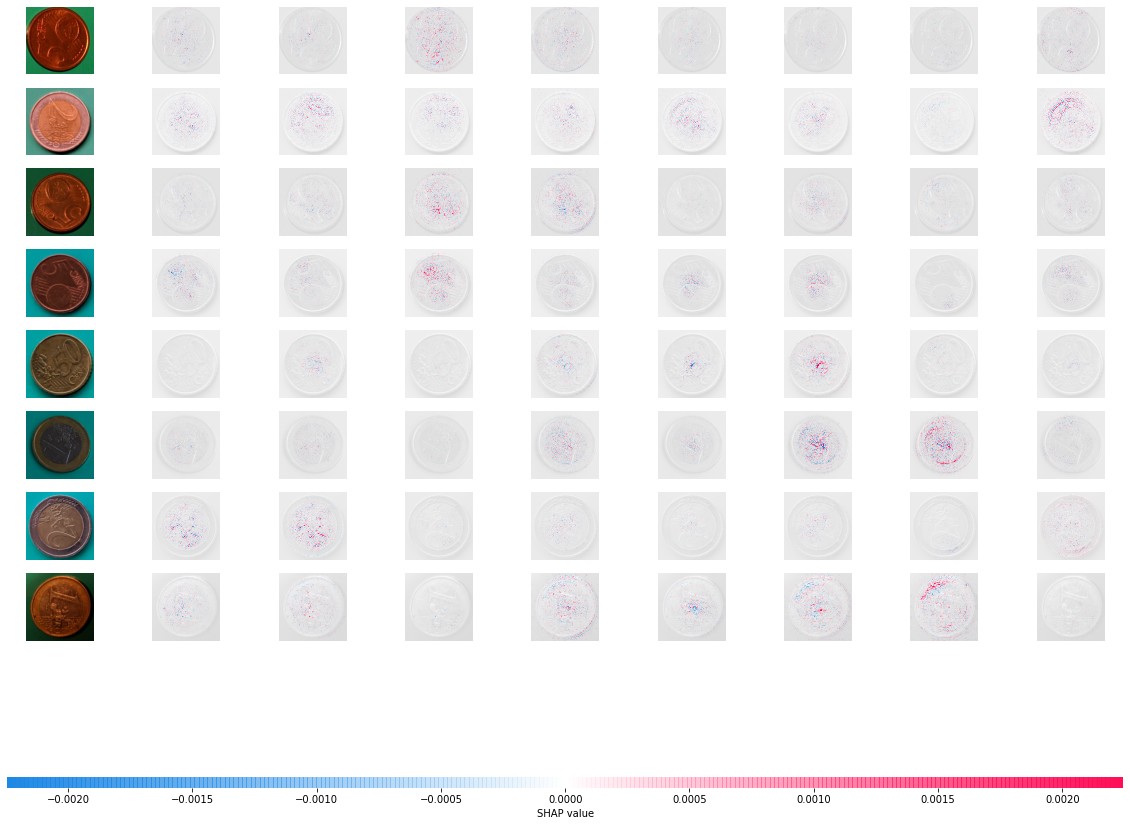

In [82]:
shap.image_plot([shap_values[i] for i in range(8)], np_x_test[:8])

## Multiple Coins